In [ ]:
import numpy as NP
import matplotlib.pyplot as PLT

from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF


class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                        ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0.5, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia

In [9]:
def test2(samples, stdref = 48.491):
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    stdref : Reference std
    """
    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                    marker='$%d$' % (i+1), ms=10, ls='',
                    mfc='k', mec='k',
                    label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
            [ p.get_label() for p in dia.samplePoints ],
            numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia

def test3(samples, stdref = 48.491):
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    stdref : Reference std
    """
    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name, color) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                    marker='.', ms=10, ls='',
                    mfc=color, mec='k',
                    label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
            [ p.get_label() for p in dia.samplePoints ],
            numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia

In [10]:
samples = [[25.939, 0.385, "Model A", "b"],
        [29.593, 0.509, "Model B", "b"],
        [33.125, 0.585, "Model C", "b"],
        [29.593, 0.509, "Model D", "b"],
        [71.215, 0.473, "Model E", "b"],
        [27.062, 0.360, "Model F", "b"],
        [38.449, 0.342, "Model G", "r"],
        [35.807, 0.609, "Model H", "r"],
        [17.831, 0.360, "Model I", "r"]]

/tmp/ipykernel_7958/1334419626.py:33: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  tr = PolarAxes.PolarTransform()
/tmp/ipykernel_7958/1028863664.py:52: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')


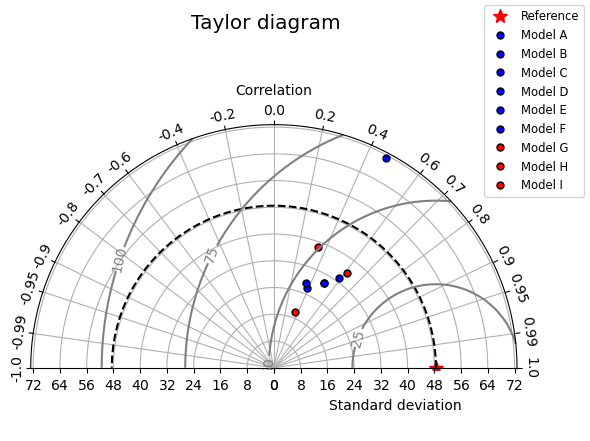

In [12]:
if __name__ == '__main__':

    # dia = test1()
    dia = test3(samples)

    # PLT.show()